<a href="https://www.kaggle.com/code/sanjidh090/one-hot-encoding-aint-working?scriptVersionId=273446979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
import pandas as pd

# Use the path that works in your environment.
# Assuming you are running this where the files are accessible.
try:
    df_train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
    
    print("--- Loaded df_train Columns ---")
    # Print all column names
    print(df_train.columns.tolist())
    
    # Print the first few rows to check if the data looks correct
    print("\n--- df_train Head (First 5 Rows) ---")
    print(df_train.head())

except FileNotFoundError:
    print("Error: The file path '/kaggle/input/playground-series-s5e11/train.csv' was not found.")
    print("Please check the path and make sure you are loading the correct file.")

--- Loaded df_train Columns ---
['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']

--- df_train Head (First 5 Rows) ---
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import os

# --- Configuration based on the notebook ---
# Note: Ensure you have a GPU environment (like a Kaggle notebook) for 'cuda'.
# Change to 'cpu' if you run into environment errors (but it will be slower).
XGB_DEVICE = 'cuda' 
XGB_TREE_METHOD = 'hist' if XGB_DEVICE == 'cpu' else 'gpu_hist'

# Best hyper-parameters found by Optuna in the original notebook (AUC: 0.926017)
OPTIMAL_PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': XGB_TREE_METHOD,
    'device': XGB_DEVICE,
    'n_estimators': 2000,
    'learning_rate': 0.015112,
    'max_depth': 12,
    'min_child_weight': 11,
    'gamma': 0.00755,
    'subsample': 0.887,
    'colsample_bytree': 0.835,
    'colsample_bylevel': 0.812,
    'colsample_bynode': 0.701,
    'reg_alpha': 0.000305,
    'reg_lambda': 0.000495,
    'seed': 42,
    'n_jobs': -1,
}

# --- 1. Data Loading ---
INPUT_PATH = '/kaggle/input/playground-series-s5e11/'
try:
    df_train = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
    df_test = pd.read_csv(os.path.join(INPUT_PATH, 'test.csv'))
    
    # Correct TARGET variable name based on your file's columns
    TARGET = 'loan_paid_back' 
    
    # Separate target variable 'y'
    y = df_train[TARGET]
    df_train.drop(TARGET, axis=1, inplace=True)
    
    # Combine for easier feature engineering
    df_full = pd.concat([df_train, df_test], ignore_index=True)

    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

except FileNotFoundError as e:
    print(f"Error loading files. Check the INPUT_PATH and file names: {e}")
    exit()

# --- 2. Simplified Feature Engineering (Corrected) ---

print("\n--- Starting Simplified Feature Engineering ---")

# IMPORTANT: 'grade' and 'sub_grade' are already combined into 'grade_subgrade' in your input.
# We SKIP the lines that tried to create this feature or drop the non-existent columns.

# Identify categorical columns and exclude 'id'
categorical_cols = df_full.select_dtypes(include=['object']).columns.tolist()
if 'id' in categorical_cols:
    categorical_cols.remove('id') 

# Basic One-Hot Encoding for remaining categorical features
print(f"One-Hot Encoding columns: {categorical_cols}")
df_full = pd.get_dummies(df_full, columns=categorical_cols, dummy_na=True)

# Fill remaining NaNs in numeric features with a placeholder (-999)
print("Filling NaNs with -999...")
df_full.fillna(-999, inplace=True)

# Separate back into training and testing sets
# We use the 'id' column from the test set for the final submission
test_ids = df_test['id']
X = df_full.iloc[:len(y)]
X_test = df_full.iloc[len(y):]

# Align columns to ensure test set matches training set columns (critical after get_dummies)
X_test = X_test[X.columns]

# --- 3. Model Training (Single XGBoost Model) ---
print("\n--- Starting XGBoost Training ---")

model = xgb.XGBClassifier(**OPTIMAL_PARAMS, enable_categorical=False)

# Use early stopping based on the notebook's cross-validation insights
model.fit(
    X, y,
    early_stopping_rounds=100,
    eval_set=[(X, y)],
    verbose=False
)

print(f"Model trained with {model.best_iteration} boosting rounds.")
print(f"Training AUC: {roc_auc_score(y, model.predict_proba(X)[:, 1]):.6f}")

# --- 4. Prediction and Submission ---
# Predict probabilities on the test set
predictions = model.predict_proba(X_test)[:, 1]

# Create submission file
submission_df = pd.DataFrame({'id': test_ids, TARGET: predictions})
submission_df.to_csv('submission_single_xgb.csv', index=False)

print("\n--- Submission File Created ---")
print("File: submission_single_xgb.csv")
print(f"Prediction head:\n{submission_df.head()}")

Train shape: (593994, 12), Test shape: (254569, 12)

--- Starting Simplified Feature Engineering ---
One-Hot Encoding columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Filling NaNs with -999...

--- Starting XGBoost Training ---


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model trained with 1999 boosting rounds.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:32:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:32:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Training AUC: 0.960424

--- Submission File Created ---
File: submission_single_xgb.csv
Prediction head:
       id  loan_paid_back
0  593994        0.936640
1  593995        0.981523
2  593996        0.501247
3  593997        0.937872
4  593998        0.961332


In [4]:

import seaborn as sns

In [5]:
train  = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')

<Axes: >

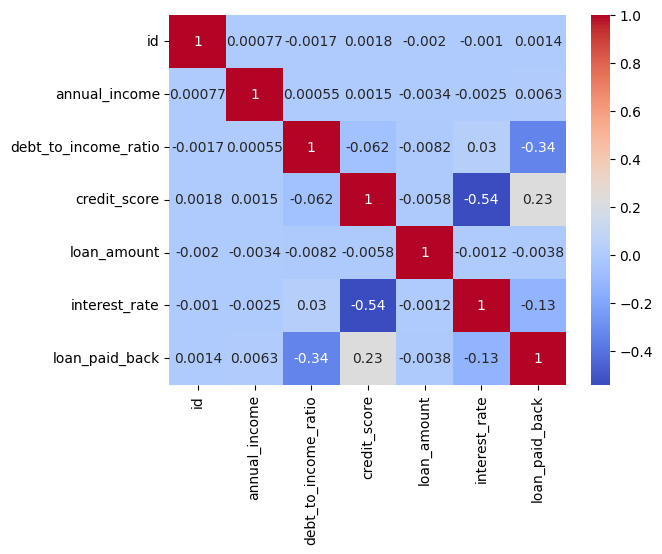

In [6]:
# Visualize correlation between numerical features
corr = train.select_dtypes(['number']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

In [7]:
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


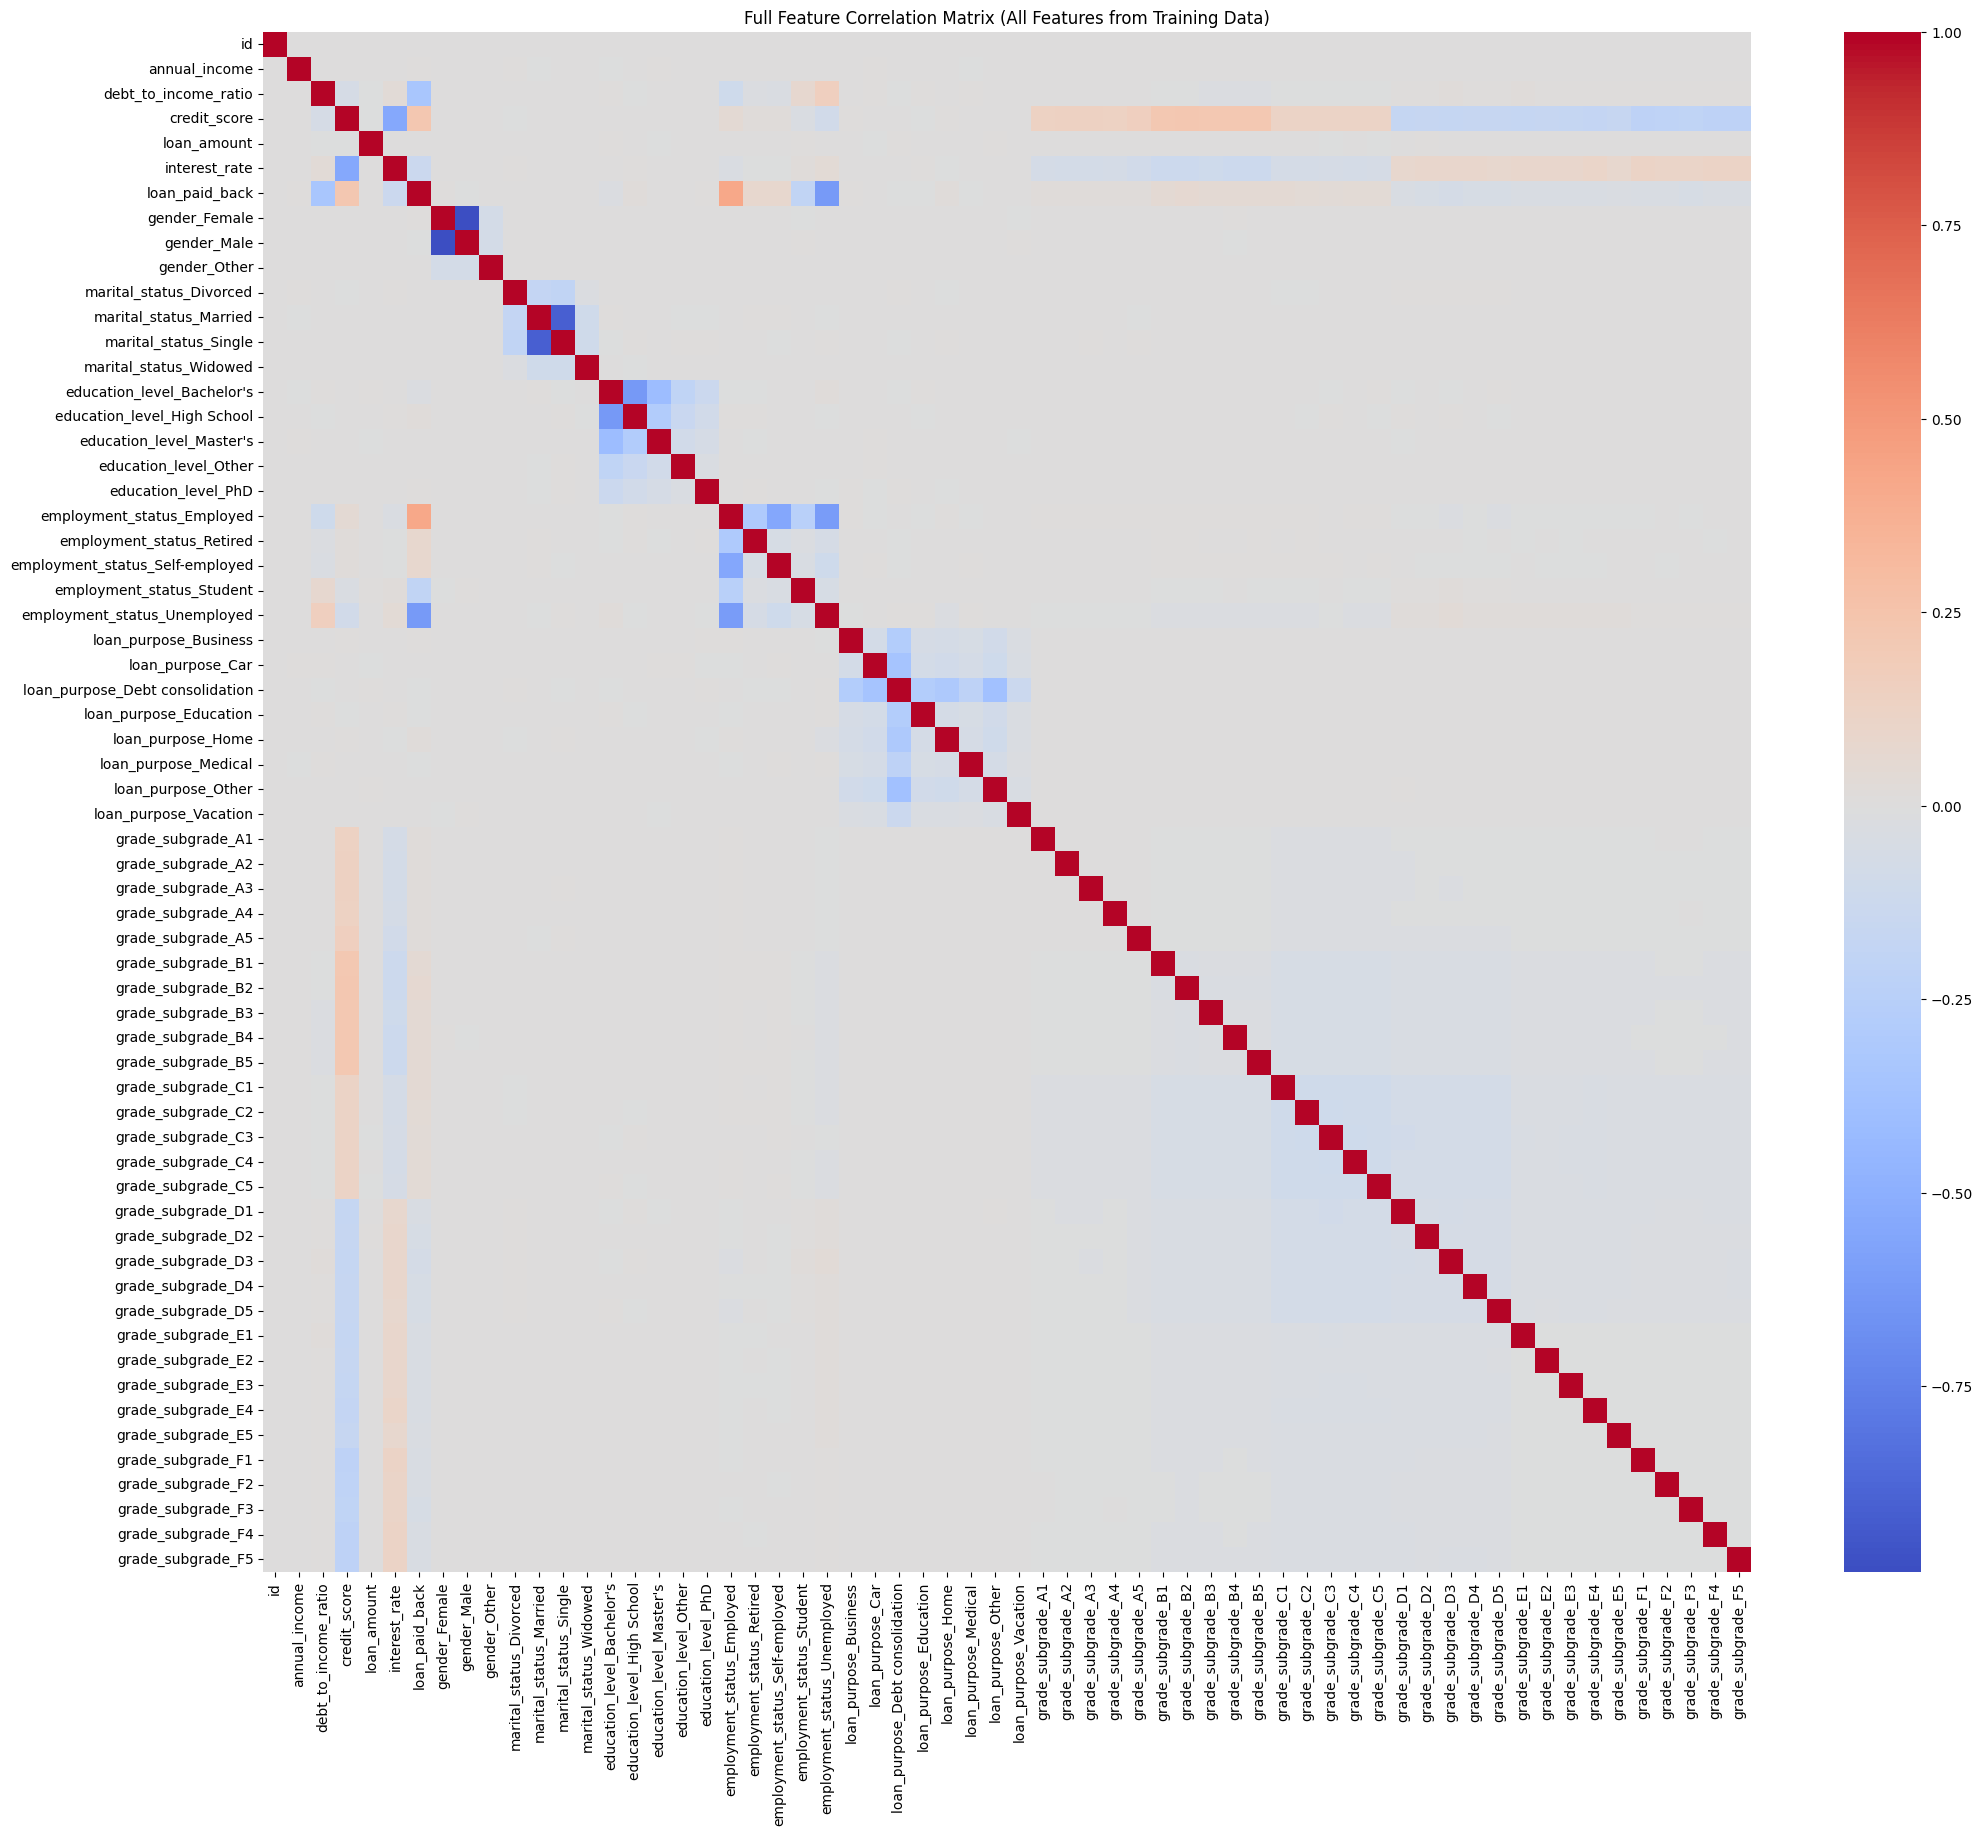

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose your training dataframe is 'train'
train = train.copy()

# Identify categorical and numeric columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()

# One-hot encode ALL categorical features (no drop_first to preserve all features)
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=False)

# Compute correlation matrix including ALL columns
corr_matrix = train_encoded.corr()

# Optional: round to 2 decimals for clarity
corr_matrix = corr_matrix.round(2)

# Visualize
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Full Feature Correlation Matrix (All Features from Training Data)')
plt.show()


In [10]:
# Compute correlation with the target variable
corr_with_target = corr_matrix['loan_paid_back'].sort_values(ascending=False)

# Show top positive and negative correlations
print("Top Positive Correlations (features that increase likelihood of repayment):")
print(corr_with_target.head(15))

print("\nTop Negative Correlations (features that decrease likelihood of repayment):")
print(corr_with_target.tail(15))


Top Positive Correlations (features that increase likelihood of repayment):
loan_paid_back                     1.00
employment_status_Employed         0.42
credit_score                       0.23
employment_status_Retired          0.08
employment_status_Self-employed    0.08
grade_subgrade_B2                  0.06
grade_subgrade_B4                  0.05
grade_subgrade_B3                  0.05
grade_subgrade_C1                  0.05
grade_subgrade_B5                  0.05
grade_subgrade_B1                  0.05
grade_subgrade_C2                  0.04
grade_subgrade_C4                  0.04
grade_subgrade_C5                  0.04
grade_subgrade_C3                  0.03
Name: loan_paid_back, dtype: float64

Top Negative Correlations (features that decrease likelihood of repayment):
grade_subgrade_F4              -0.04
grade_subgrade_F5              -0.04
grade_subgrade_E2              -0.04
grade_subgrade_F1              -0.04
grade_subgrade_E4              -0.04
grade_subgrade_E3        

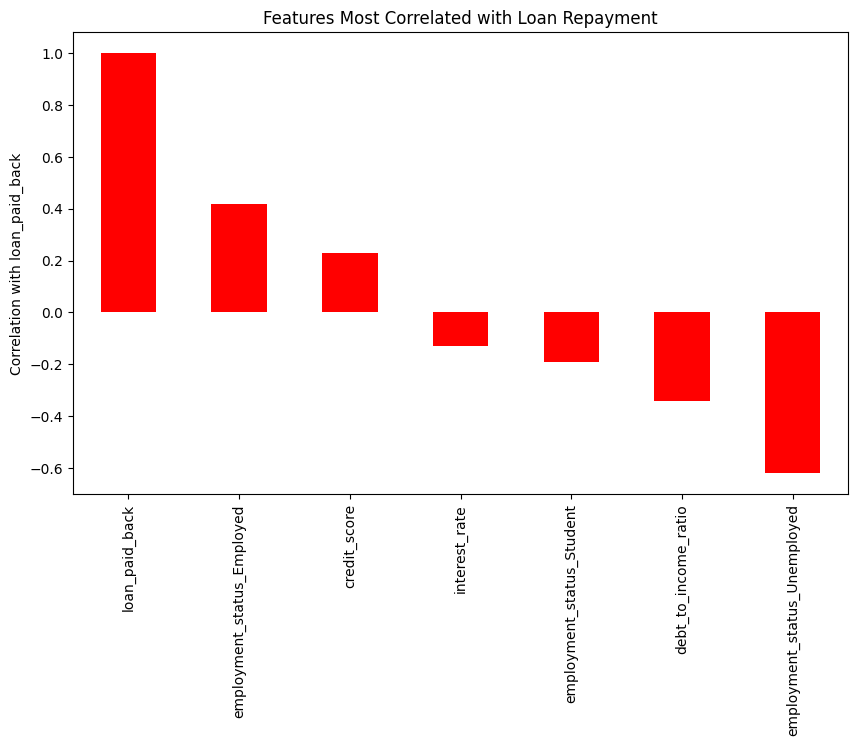

In [11]:
import matplotlib.pyplot as plt

top_features = corr_with_target[abs(corr_with_target) > 0.1]  # filter strongest ones
plt.figure(figsize=(10,6))
top_features.plot(kind='bar', color='red')
plt.title('Features Most Correlated with Loan Repayment')
plt.ylabel('Correlation with loan_paid_back')
plt.show()


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


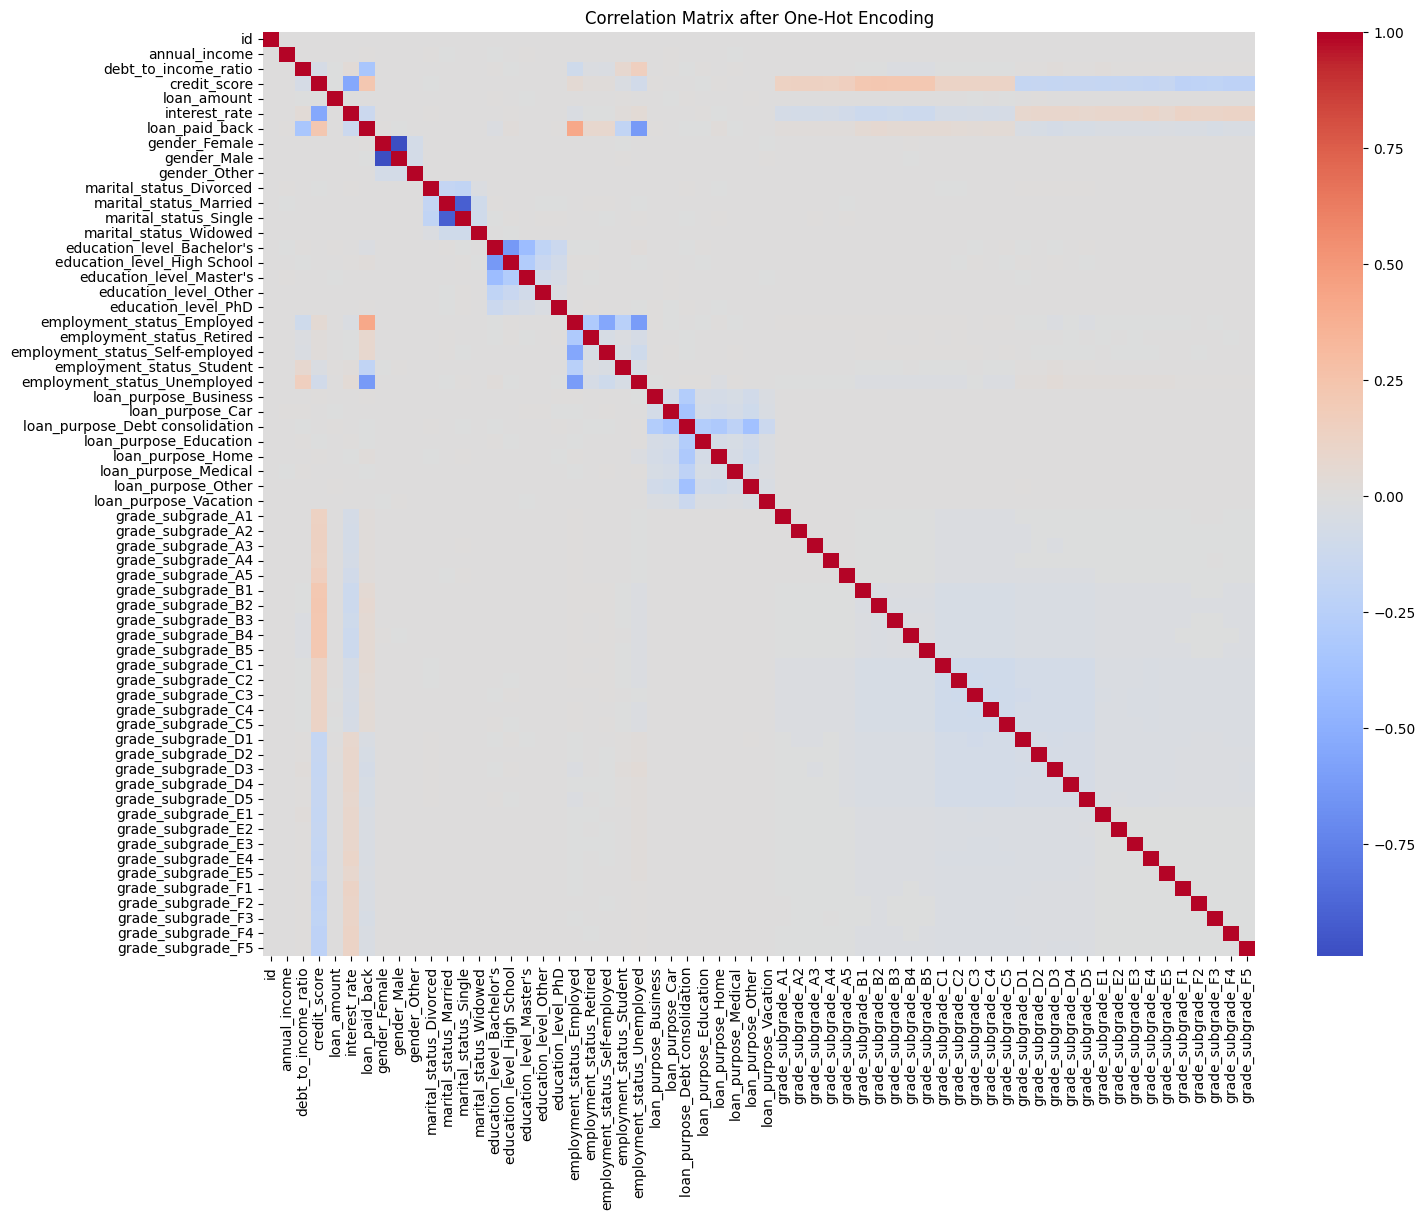

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix after One-Hot Encoding')
plt.show()


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


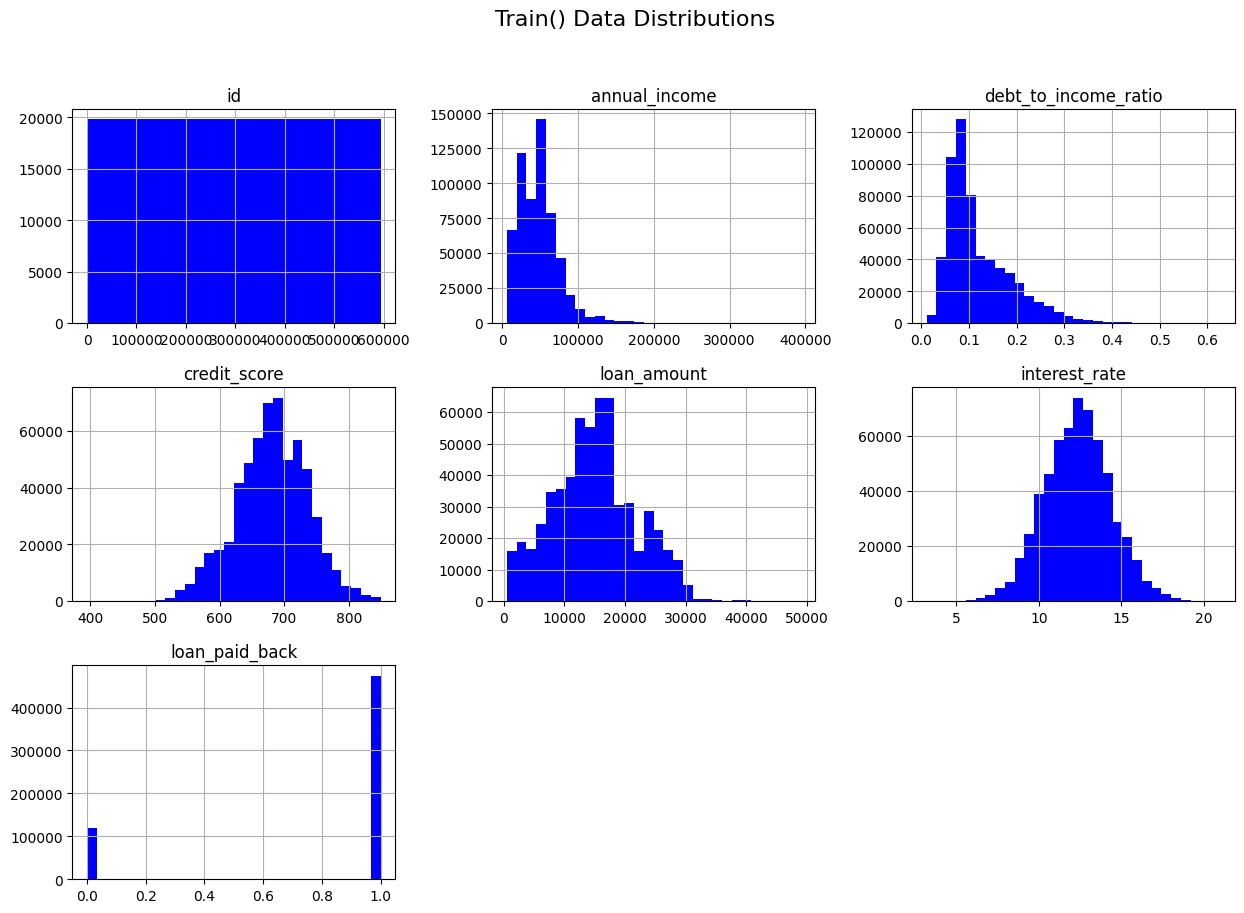

In [15]:
import matplotlib.pyplot as plt

train.hist(bins=30,figsize=(15, 10),color= 'blue')
plt.suptitle("Train() Data Distributions", fontsize=16)
plt.show()

In [16]:
target = 'loan_paid_back'

Numeric columns used for distribution plots:
['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']

Distribution analysis (all numeric/object columns converted)



/tmp/ipykernel_19/3043445107.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


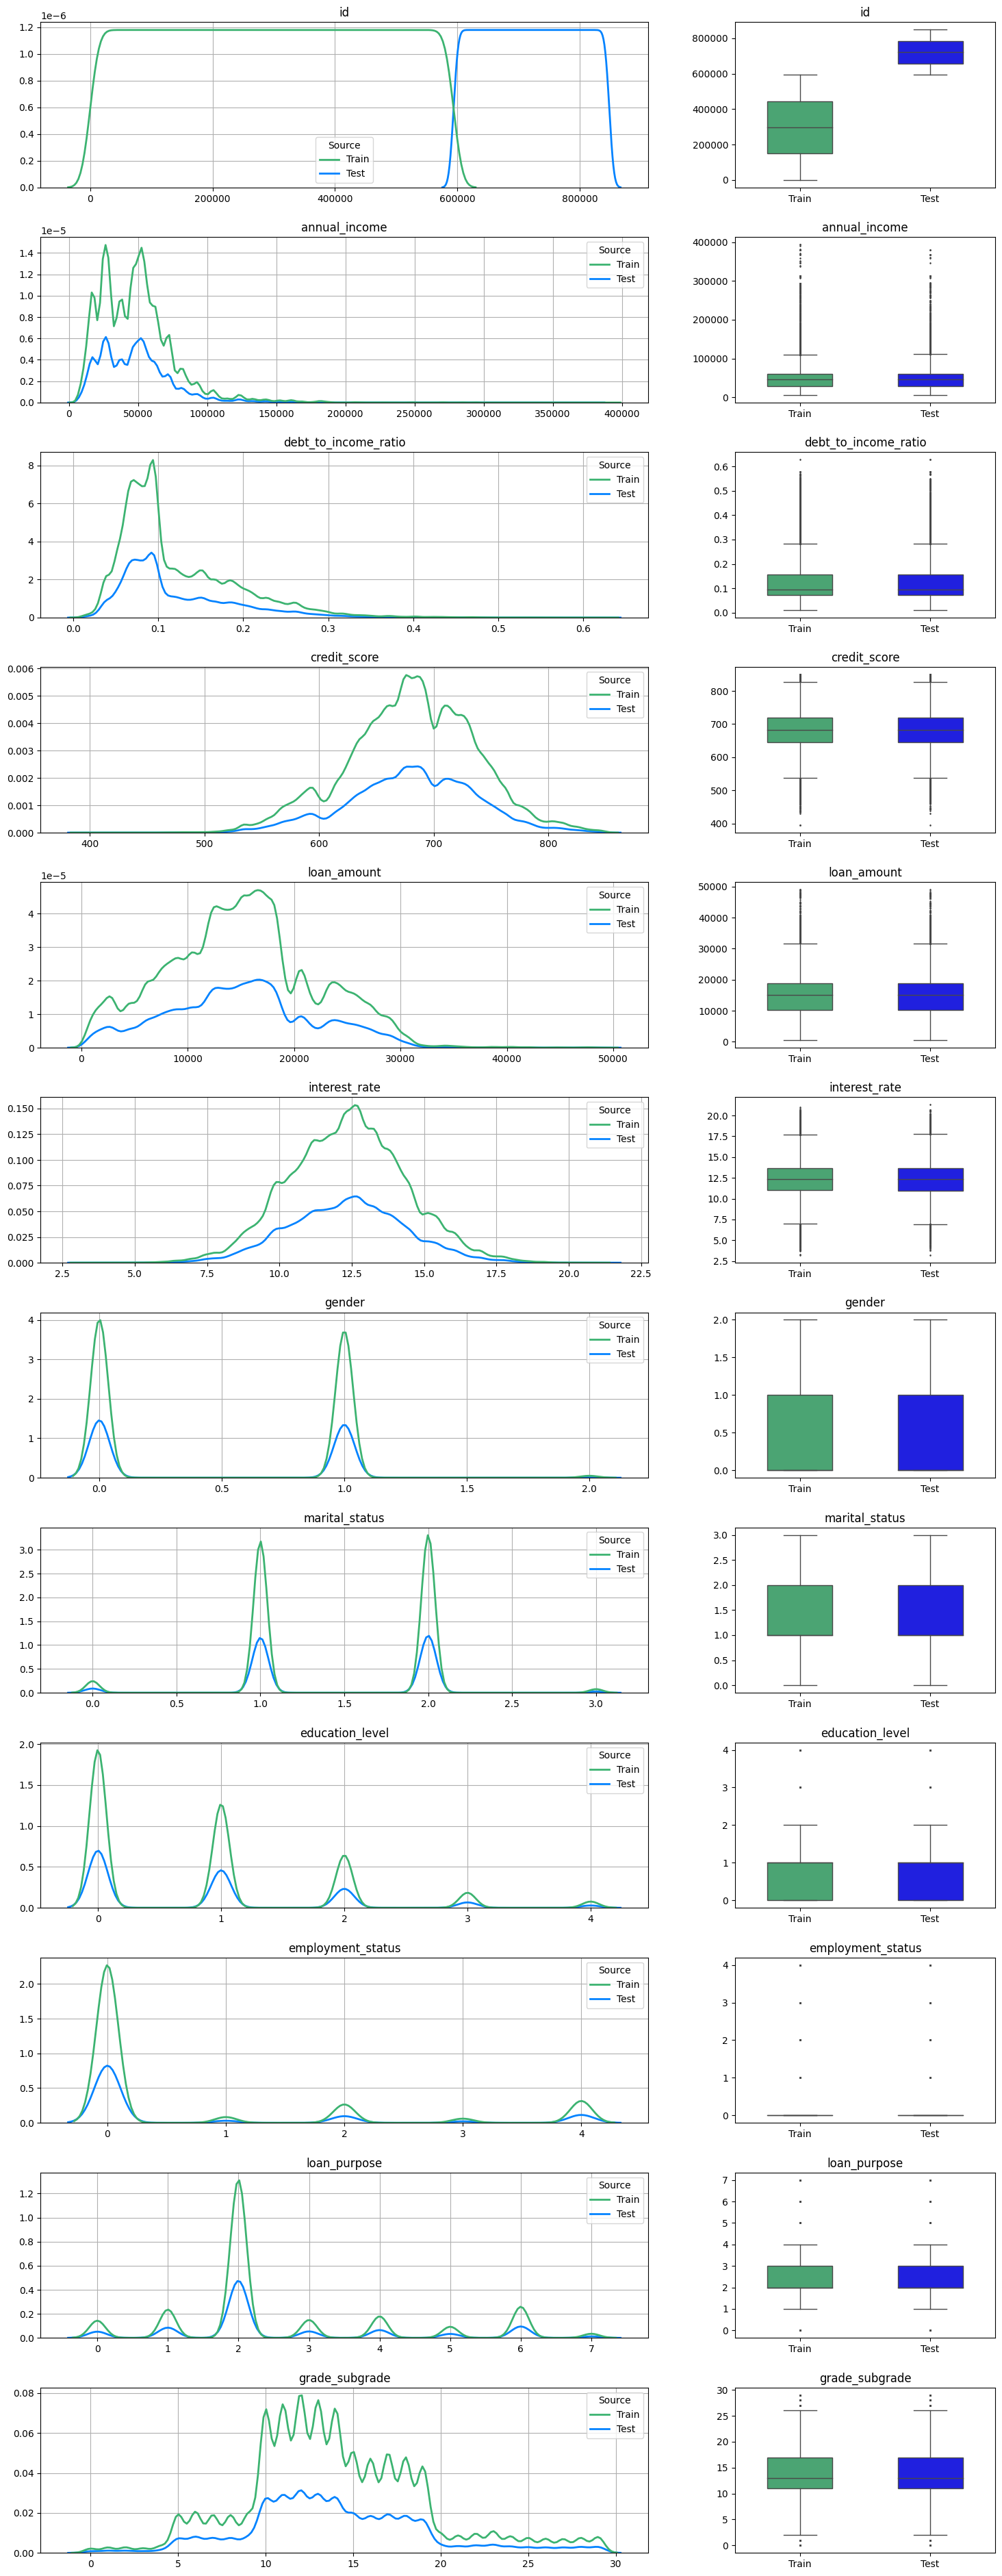

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def convert_all_to_numeric(train, test):
    """
    Converts ALL columns in train/test to numeric (LabelEncoding for objects),
    safely handling columns that exist only in one dataset.
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder

    tr, te = train.copy(), test.copy()
    encoders = {}

    # unify columns intersection (ignore target like Dropout that’s train-only)
    common_cols = sorted(set(tr.columns).intersection(set(te.columns)))

    for col in common_cols:
        if tr[col].dtype == "O" or str(tr[col].dtype).startswith("category"):
            le = LabelEncoder()
            combined = pd.concat([tr[col].astype(str), te[col].astype(str)], axis=0)
            le.fit(combined)
            tr[col] = le.transform(tr[col].astype(str))
            te[col] = le.transform(te[col].astype(str))
            encoders[col] = le
        else:
            tr[col] = pd.to_numeric(tr[col], errors="coerce")
            te[col] = pd.to_numeric(te[col], errors="coerce")

    # handle train-only numeric columns like target
    for col in set(tr.columns) - set(te.columns):
        if tr[col].dtype == "O":
            le = LabelEncoder()
            tr[col] = le.fit_transform(tr[col].astype(str))
        else:
            tr[col] = pd.to_numeric(tr[col], errors="coerce")

    # clean infinities / NaNs
    tr.replace([np.inf, -np.inf], np.nan, inplace=True)
    te.replace([np.inf, -np.inf], np.nan, inplace=True)
    tr.fillna(tr.mean(numeric_only=True), inplace=True)
    te.fillna(te.mean(numeric_only=True), inplace=True)

    num_cols = tr.select_dtypes(include="number").columns.tolist()
    return tr, te, num_cols


def dist_plots(train, test, num_features):
    """
    Plot KDE + Boxplots for numeric columns.
    """
    print("\nDistribution analysis (all numeric/object columns converted)\n")
    df = pd.concat(
        [train[num_features].assign(Source="Train"),
         test[num_features].assign(Source="Test")],
        axis=0, ignore_index=True
    )

    n = len(num_features)
    fig, axes = plt.subplots(
        n, 2,
        figsize=(18, n * 4),
        gridspec_kw={"hspace": 0.3, "wspace": 0.2, "width_ratios": [0.70, 0.30]}
    )
    if n == 1:
        axes = np.array([axes])

    for i, col in enumerate(num_features):
        # KDE
        ax = axes[i, 0]
        sns.kdeplot(data=df, x=col, hue="Source",
                    palette=["#3cb371", "#0483ff"], ax=ax, linewidth=2)
        ax.set(xlabel="", ylabel="")
        ax.set_title(f"{col}")
        ax.grid()

        # Boxplot
        ax = axes[i, 1]
        sns.boxplot(data=df, y=col, x="Source", width=0.5,
                    linewidth=1, fliersize=1, ax=ax, palette=["#3cb371", "b"])
        ax.set(xlabel="", ylabel="")
        ax.set_title(f"{col}")
        ax.set_xticklabels(["Train", "Test"])

    plt.tight_layout()
    plt.show()
    
# 1️⃣ Convert everything to numeric
tr_all, te_all, numeric_cols = convert_all_to_numeric(train, test)

print("Numeric columns used for distribution plots:")
print(numeric_cols)

# 2️⃣ Plot all feature distributions
dist_plots(tr_all, te_all, [c for c in numeric_cols if c != target])

In [18]:
train_cols = ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back']

for i in train_cols:
    print('**=='*20)
    print(f"Unique Values of column {i}")
    print(f"{train[i].value_counts()}")
    

**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==
Unique Values of column id
id
593993    1
0         1
1         1
2         1
3         1
         ..
13        1
14        1
15        1
16        1
17        1
Name: count, Length: 593994, dtype: int64
**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==
Unique Values of column annual_income
annual_income
51351.71    238
25499.88    227
24113.12    219
56547.75    209
26386.33    187
           ... 
52885.63      1
41003.18      1
69053.55      1
63372.41      1
50688.93      1
Name: count, Length: 119728, dtype: int64
**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==**==
Unique Values of column debt_to_income_ratio
debt_to_income_ratio
0.09000    11440
0.09300    11160
0.09700     9508
0.07900     9099
0.09400     8976
           ...  
0.55400        1
0.47700        1
0.07633        1
0.07890        1
0.09910        1
Name: count, Length: 526, dtyp

In [19]:
train.describe()

id  annual_income  debt_to_income_ratio   credit_score  \
count  593994.000000  593994.000000         593994.000000  593994.000000   
mean   296996.500000   48212.202976              0.120696     680.916009   
std    171471.442235   26711.942078              0.068573      55.424956   
min         0.000000    6002.430000              0.011000     395.000000   
25%    148498.250000   27934.400000              0.072000     646.000000   
50%    296996.500000   46557.680000              0.096000     682.000000   
75%    445494.750000   60981.320000              0.156000     719.000000   
max    593993.000000  393381.740000              0.627000     849.000000   

         loan_amount  interest_rate  loan_paid_back  
count  593994.000000  593994.000000   593994.000000  
mean    15020.297629      12.356345        0.798820  
std      6926.530568       2.008959        0.400883  
min       500.090000       3.200000        0.000000  
25%     10279.620000      10.990000        1.000000  
50%     15000.220000      12.370000        1.000000  
75%     18858.580000      13.680000        1.000000  
max     48959.950000      20.990000        1.000000

**There's a better way to do this**

In [20]:
for col in train_cols:
    print(f"\n{'='*80}")
    print(f"🔹 Column: {col}")
    print(f"Unique values: {train[col].nunique()}")
    print(train[col].value_counts(dropna=False).head(10))  # top 10 most common



🔹 Column: id
Unique values: 593994
id
593993    1
0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
Name: count, dtype: int64

🔹 Column: annual_income
Unique values: 119728
annual_income
51351.71    238
25499.88    227
24113.12    219
56547.75    209
26386.33    187
28991.07    185
16077.08    170
46949.29    160
53981.90    152
52628.69    146
Name: count, dtype: int64

🔹 Column: debt_to_income_ratio
Unique values: 526
debt_to_income_ratio
0.090    11440
0.093    11160
0.097     9508
0.079     9099
0.094     8976
0.098     8647
0.071     8192
0.096     7715
0.063     7579
0.067     7373
Name: count, dtype: int64

🔹 Column: credit_score
Unique values: 399
credit_score
678    6526
661    5801
674    5793
708    5661
681    5635
672    5622
669    5618
685    5557
713    5544
676    5508
Name: count, dtype: int64

🔹 Column: loan_amount
Unique values: 111570
loan_amount
12892.25    412
15212.88    338
16004.97    282
1838.88     2

In [21]:
summary = train[train_cols].nunique().reset_index()
summary.columns = ['Column', 'Unique_Values']
summary


Column  Unique_Values
0                     id         593994
1          annual_income         119728
2   debt_to_income_ratio            526
3           credit_score            399
4            loan_amount         111570
5          interest_rate           1454
6                 gender              3
7         marital_status              4
8        education_level              5
9      employment_status              5
10          loan_purpose              8
11        grade_subgrade             30
12        loan_paid_back              2

In [22]:
from ydata_profiling import ProfileReport

profile = ProfileReport(train[train_cols], title="Loan Data Report")
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


Feature: gender | Unique values: 3 | Type: object


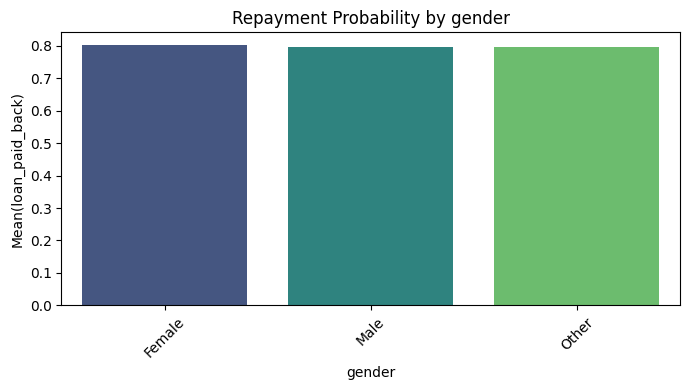


Feature: marital_status | Unique values: 4 | Type: object


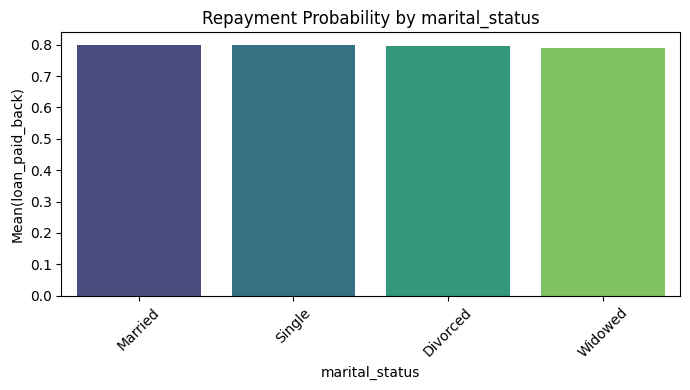


Feature: education_level | Unique values: 5 | Type: object


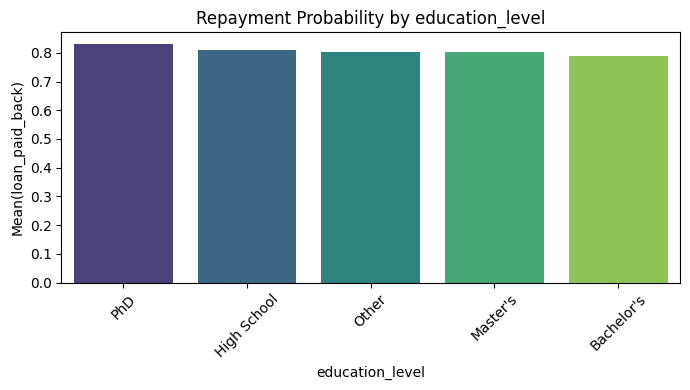


Feature: employment_status | Unique values: 5 | Type: object


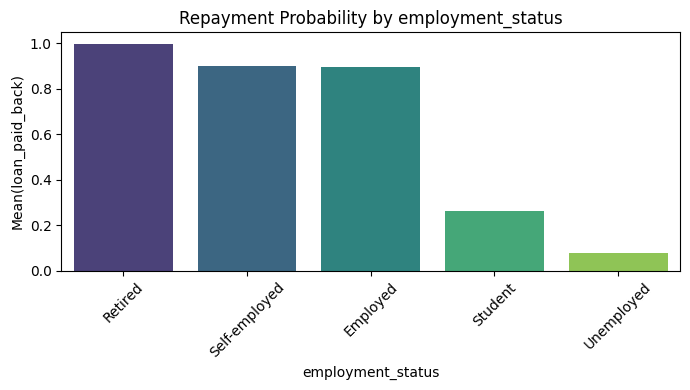


Feature: loan_purpose | Unique values: 8 | Type: object


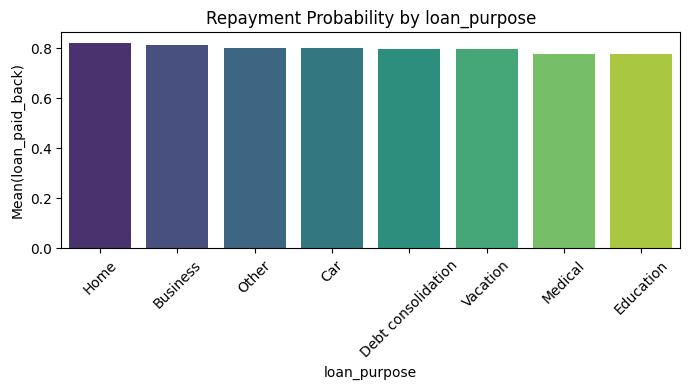


Feature: grade_subgrade | Unique values: 30 | Type: object


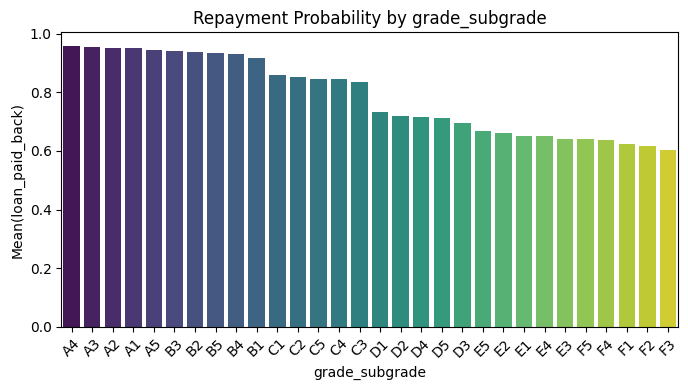

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Target column
target = 'loan_paid_back'

# Skip high-cardinality columns
max_uniques = 30

# Select columns to visualize (exclude ID and target)
features = [c for c in train.columns if c not in ['id', target]]

# Prepare the plots
for col in features:
    n_unique = train[col].nunique()
    dtype = train[col].dtype
    
    # Skip columns with too many unique values
    if n_unique > max_uniques:
        continue
    
    print(f"\n{'='*80}")
    print(f"Feature: {col} | Unique values: {n_unique} | Type: {dtype}")
    
    plt.figure(figsize=(7, 4))
    
    if np.issubdtype(dtype, np.number):
        # Numeric feature → show boxplot distribution by target
        sns.boxplot(x=target, y=col, data=train, palette="Set2")
        plt.title(f"{col} vs. Loan Paid Back (Boxplot)")
    else:
        # Categorical feature → show repayment rate per category
        temp = train.groupby(col)[target].mean().sort_values(ascending=False)
        sns.barplot(x=temp.index, y=temp.values, palette="viridis")
        plt.title(f"Repayment Probability by {col}")
        plt.ylabel("Mean(loan_paid_back)")
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


In [24]:
import pandas as pd
from scipy import stats
import numpy as np

target = 'loan_paid_back'

# Select numeric features only
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [target, 'id']]

anova_results = []

for col in numeric_cols:
    # Separate the two groups
    group1 = train[train[target] == 1][col].dropna()
    group0 = train[train[target] == 0][col].dropna()
    
    # Run ANOVA (F-test)
    f_stat, p_val = stats.f_oneway(group1, group0)
    
    anova_results.append({
        'Feature': col,
        'F-Statistic': f_stat,
        'p-Value': p_val
    })

# Create summary DataFrame
anova_df = pd.DataFrame(anova_results).sort_values(by='p-Value')
anova_df['Significant'] = anova_df['p-Value'] < 0.05

print("🔹 ANOVA Results:")
display(anova_df)


🔹 ANOVA Results:


Feature   F-Statistic   p-Value  Significant
1  debt_to_income_ratio  75431.295535  0.000000         True
2          credit_score  34583.137118  0.000000         True
4         interest_rate  10401.158657  0.000000         True
0         annual_income     23.768888  0.000001         True
3           loan_amount      8.407505  0.003737         True

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder

target = 'loan_paid_back'

anova_results = []
chi2_results = []

# Split features into numeric & categorical
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [target, 'id']]

categorical_cols = [c for c in train.columns if c not in numeric_cols + [target, 'id']]

# --- 1️⃣ ANOVA for numeric features ---
for col in numeric_cols:
    group1 = train.loc[train[target] == 1, col].dropna()
    group0 = train.loc[train[target] == 0, col].dropna()
    if len(group1) > 1 and len(group0) > 1:
        f_stat, p_val = stats.f_oneway(group1, group0)
        anova_results.append({
            'Feature': col,
            'Test': 'ANOVA (numeric)',
            'Statistic': f_stat,
            'p-Value': p_val
        })

# --- 2️⃣ Chi-square for categorical features ---
for col in categorical_cols:
    # Encode if needed
    temp = train[[col, target]].dropna()
    contingency = pd.crosstab(temp[col], temp[target])
    
    # Chi-square test
    if contingency.shape[0] > 1:
        chi2, p_val, dof, ex = stats.chi2_contingency(contingency)
        chi2_results.append({
            'Feature': col,
            'Test': 'Chi-Square (categorical)',
            'Statistic': chi2,
            'p-Value': p_val
        })

# --- 3️⃣ Combine results ---
results_df = pd.DataFrame(anova_results + chi2_results)
results_df['Significant'] = results_df['p-Value'] < 0.05
results_df = results_df.sort_values(by='p-Value')

print("🔹 Feature Significance (ANOVA + Chi-Square):")
display(results_df)


🔹 Feature Significance (ANOVA + Chi-Square):


Feature                      Test      Statistic  \
1   debt_to_income_ratio           ANOVA (numeric)   75431.295535   
2           credit_score           ANOVA (numeric)   34583.137118   
4          interest_rate           ANOVA (numeric)   10401.158657   
8      employment_status  Chi-Square (categorical)  256259.857065   
10        grade_subgrade  Chi-Square (categorical)   30871.161938   
7        education_level  Chi-Square (categorical)     383.433795   
9           loan_purpose  Chi-Square (categorical)     391.327802   
5                 gender  Chi-Square (categorical)      32.812778   
0          annual_income           ANOVA (numeric)      23.768888   
3            loan_amount           ANOVA (numeric)       8.407505   
6         marital_status  Chi-Square (categorical)       4.122237   

         p-Value  Significant  
1   0.000000e+00         True  
2   0.000000e+00         True  
4   0.000000e+00         True  
8   0.000000e+00         True  
10  0.000000e+00         True  
7   1.055186e-81         True  
9   1.725854e-80         True  
5   7.495415e-08         True  
0   1.086521e-06         True  
3   3.736888e-03         True  
6   2.485637e-01        False

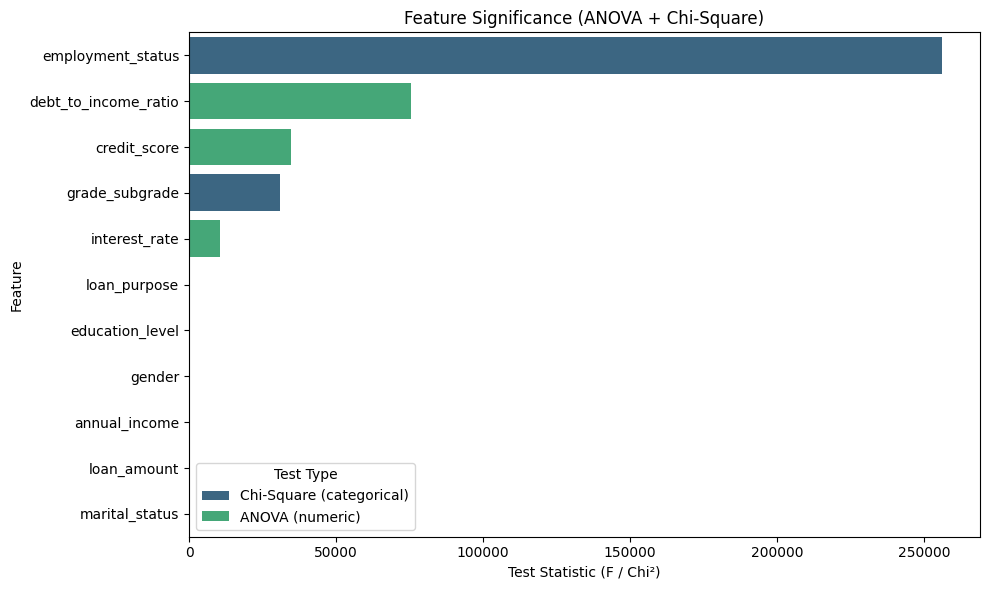

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort and plot
sorted_df = results_df.sort_values(by='Statistic', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=sorted_df,
    x='Statistic',
    y='Feature',
    hue='Test',
    dodge=False,
    palette='viridis'
)
plt.title("Feature Significance (ANOVA + Chi-Square)")
plt.xlabel("Test Statistic (F / Chi²)")
plt.ylabel("Feature")
plt.legend(title="Test Type")
plt.tight_layout()
plt.show()


In [27]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


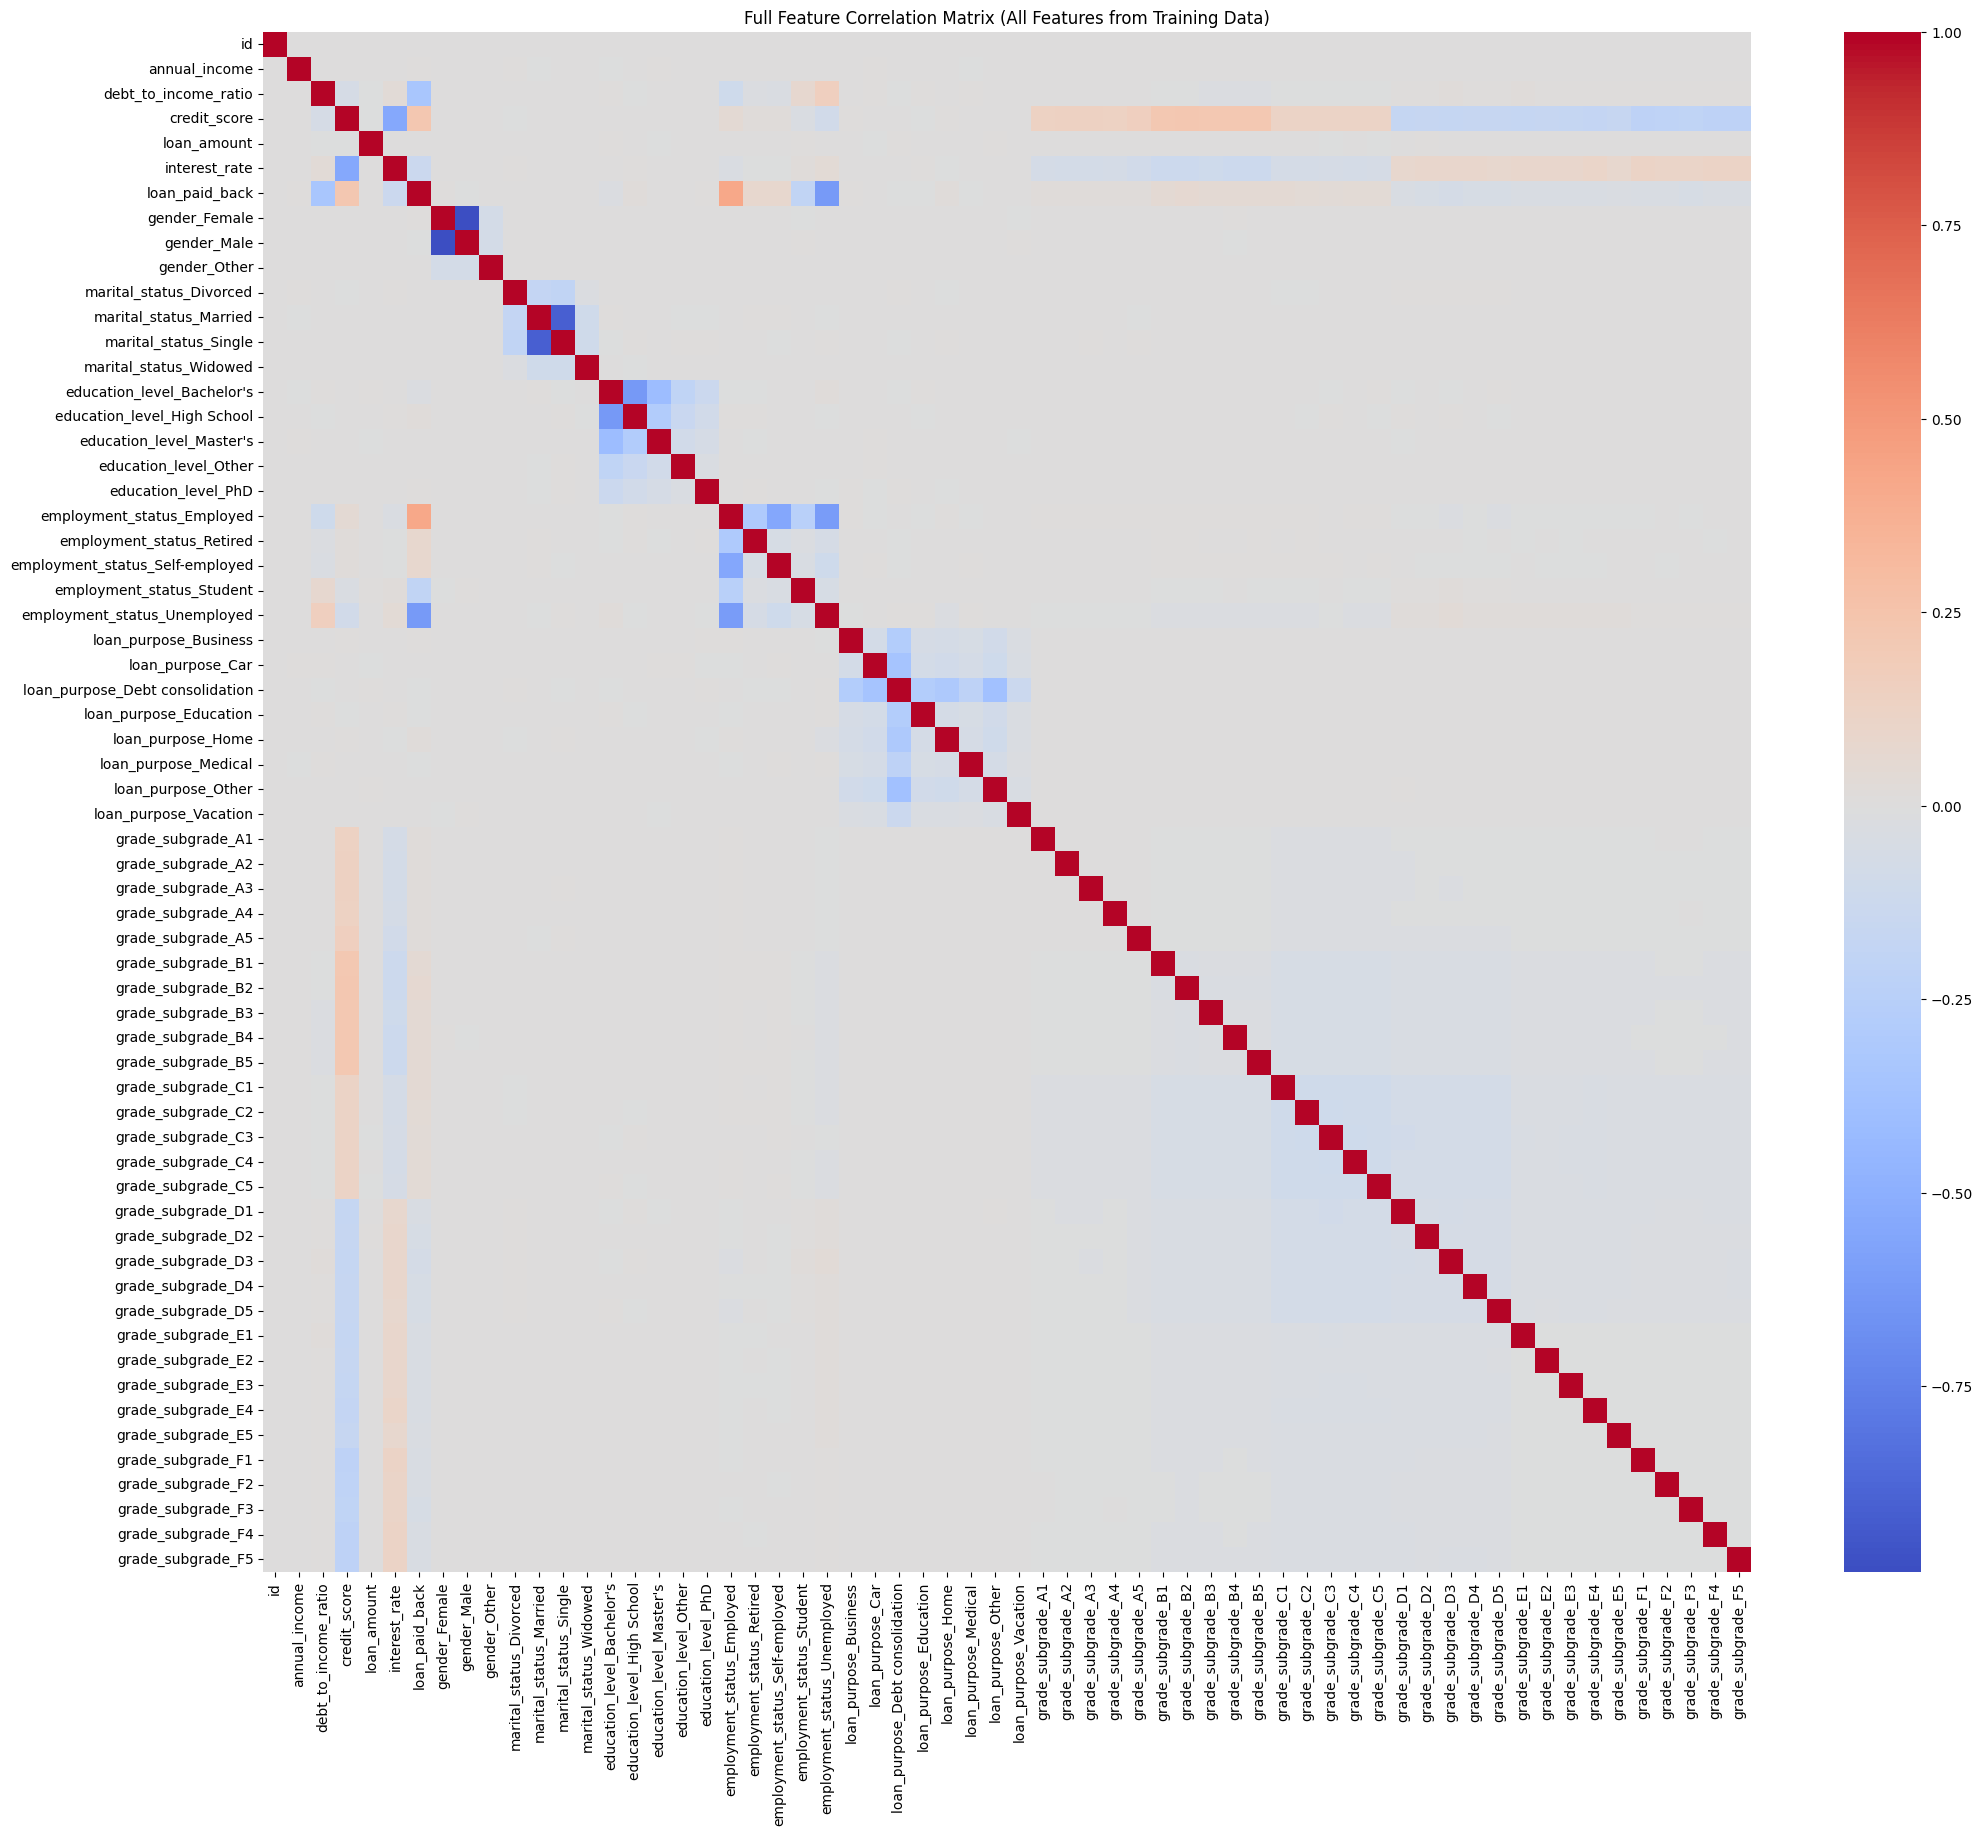

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose your training dataframe is 'train'

# Identify categorical and numeric columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()

# One-hot encode ALL categorical features (no drop_first to preserve all features)
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=False)

# Compute correlation matrix including ALL columns
corr_matrix = train_encoded.corr()

# Optional: round to 2 decimals for clarity
corr_matrix = corr_matrix.round(2)

# Visualize
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Full Feature Correlation Matrix (All Features from Training Data)')
plt.show()


**#Check new ones **

In [29]:
# ==============================================================
# 1. Imports
# ==============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve
# Updated Imports: LightGBM, XGBoost, and the new CatBoost
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================================================
# 2. Load Data
# ==============================================================
# NOTE: File paths assume a Kaggle environment; adjust if running elsewhere
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

# ==============================================================
# 3. Basic Setup
# ==============================================================
X = train.drop(columns=['loan_paid_back', 'id'])
y = train['loan_paid_back']
X_test = test.drop(columns=['id'])

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

# ==============================================================
# 4. Feature Preprocessing (Only Numeric/XGBoost/LightGBM)
# NOTE: We keep the encoded data for models that require it (LGBM, XGBoost)
# ==============================================================
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ct = ColumnTransformer(
    transformers=[('ohe', ohe, cat_cols)],
    remainder='passthrough'
)

# Fit-transform train, transform test
X_encoded = ct.fit_transform(X)
X_test_encoded = ct.transform(X_test)

# Convert to DataFrame with aligned columns
encoded_cols = ct.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=encoded_cols)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_cols)

# ==============================================================
# 5. Split Train/Validation for Curves
# ==============================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Create a second split using the UN-ENCODED data for CatBoost
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_test_cat = X_test.copy()

# ==============================================================
# 6. CatBoost Classifier (The Special Something)
# CatBoost natively handles categorical features, so we use the un-encoded data.
# ==============================================================
print("\n--- 6. CatBoost Classifier ---")
# CatBoost's advanced optimization includes ordering principle and native feature handling
cat_model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.05,
    eval_metric='AUC',
    random_seed=42,
    verbose=50,
    early_stopping_rounds=30,
    # Use the column names identified in Section 3
    cat_features=cat_cols 
)

cat_model.fit(
    X_train_cat, y_train_cat,
    eval_set=[(X_val_cat, y_val_cat)]
)

y_val_pred_cat = cat_model.predict_proba(X_val_cat)[:, 1]
auc_cat = roc_auc_score(y_val_cat, y_val_pred_cat)
print(f"CatBoost AUC: {auc_cat:.4f}")

# Plotting the training curve
evals_result_cat = cat_model.get_evals_result()
plt.figure(figsize=(6,5))
plt.plot(evals_result_cat['validation']['AUC'], label='Validation AUC')
plt.title('CatBoost AUC Training Curve')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend()
plt.savefig('catboost_training_curve.png')
plt.close()

# Predict test
cat_pred = cat_model.predict_proba(X_test_cat)[:, 1]
pd.DataFrame({'id': test['id'], 'loan_paid_back': cat_pred}).to_csv('catboost_predictions.csv', index=False)


# ==============================================================
# 7. LightGBM (FIXED: Callbacks and Plotting)
# ==============================================================
print("\n--- 7. LightGBM ---")
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

evals_result_lgb = {}
early_stopping = lgb.early_stopping(stopping_rounds=30, verbose=50)
record_eval = lgb.record_evaluation(evals_result_lgb)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val], 
    num_boost_round=300,
    callbacks=[early_stopping, record_eval]
)

y_val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
auc_lgb = roc_auc_score(y_val, y_val_pred_lgb)
print(f"LightGBM AUC: {auc_lgb:.4f}")

lgb.plot_metric(evals_result_lgb) 
plt.title('LightGBM AUC Training Curve')
plt.savefig('lgbm_training_curve.png')
plt.close()

lgb_pred = lgb_model.predict(X_test_encoded, num_iteration=lgb_model.best_iteration)
pd.DataFrame({'id': test['id'], 'loan_paid_back': lgb_pred}).to_csv('lgbm_predictions.csv', index=False)


# ==============================================================
# 8. XGBoost (FIXED: Eval Set and Plotting)
# ==============================================================
print("\n--- 8. XGBoost ---")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    early_stopping_rounds=30, 
    verbose=False
)

y_val_pred_xgb = xgb_model.predict_proba(X_val)[:,1]
auc_xgb = roc_auc_score(y_val, y_val_pred_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

results = xgb_model.evals_result()
plt.figure(figsize=(6,5))
plt.plot(results['validation_0']['auc'], label='Train AUC')
plt.plot(results['validation_1']['auc'], label='Validation AUC') 
plt.title('XGBoost AUC Training Curve')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.legend()
plt.savefig('xgboost_training_curve.png')
plt.close()

xgb_pred = xgb_model.predict_proba(X_test_encoded)[:,1]
pd.DataFrame({'id': test['id'], 'loan_paid_back': xgb_pred}).to_csv('xgboost_predictions.csv', index=False)


# ==============================================================
# 9. Weighted Averaging Ensemble (Advanced Ensemble)
# Simple ensemble using equal weights for demonstration
# ==============================================================
print("\n--- 9. Weighted Averaging Ensemble ---")

# Combine predictions on the test set
ensemble_pred = (
    lgb_pred * 0.33 +
    xgb_pred * 0.33 +
    cat_pred * 0.34 # Slightly higher weight for CatBoost (arbitrary for demonstration)
)

# Create final submission file
pd.DataFrame({
    'id': test['id'], 
    'loan_paid_back': ensemble_pred
}).to_csv('ensemble_predictions.csv', index=False)

# ==============================================================
# 10. Summary
# ==============================================================
print(f"\nModel Summary (Validation AUC):")
print(f"CatBoost:            {auc_cat:.4f} (Used un-encoded data)")
print(f"LightGBM:            {auc_lgb:.4f} (Used encoded data)")
print(f"XGBoost:             {auc_xgb:.4f} (Used encoded data)")
print("Ensemble predictions saved to 'ensemble_predictions.csv'.")
print("All individual predictions and training curves saved.")

Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Numerical: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

--- 6. CatBoost Classifier ---
0:	test: 0.8960369	best: 0.8960369 (0)	total: 388ms	remaining: 3m 52s
50:	test: 0.9125884	best: 0.9125884 (50)	total: 14.8s	remaining: 2m 39s
100:	test: 0.9143130	best: 0.9143130 (100)	total: 29.9s	remaining: 2m 27s
150:	test: 0.9151136	best: 0.9151136 (150)	total: 44.8s	remaining: 2m 13s
200:	test: 0.9157987	best: 0.9157987 (200)	total: 59.9s	remaining: 1m 58s
250:	test: 0.9162686	best: 0.9162686 (250)	total: 1m 14s	remaining: 1m 43s
300:	test: 0.9169198	best: 0.9169198 (300)	total: 1m 30s	remaining: 1m 30s
350:	test: 0.9175800	best: 0.9175800 (350)	total: 1m 46s	remaining: 1m 15s
400:	test: 0.9180585	best: 0.9180585 (400)	total: 2m 2s	remaining: 1m 1s
450:	test: 0.9184137	best: 0.9184137 (450)	total: 2m 18s	remaining: 45.8s
500:	test: 0.91

In [30]:
# #Food for tjpoghty 
# Model Summary (Validation AUC):
# CatBoost:            0.9169 (Used un-encoded data)
# LightGBM:            0.9200 (Used encoded data)
# XGBoost:             0.9187 (Used encoded data)
# Ensemble predictions saved to 'ensemble_predictions.csv'.
# All individual predictions and training curves saved.

In [31]:
# !kaggle competitions submit -c playground-series-s5e11 -f submission.csv -m "LightGBM AUC 0.9204"
